Подключу необходимые библиотеки и файлы

In [23]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/Yuichir0/Telecom/thinkdsp.py

import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate, UncorrelatedGaussianNoise, read_wave, Spectrogram
from scipy.stats import linregress
import scipy.fftpack

### Упражнение 6.1
В этой главе утрверждается, что analyze1 требует времени пропорционально n^3, а analyze2 - пропорционально n^2. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время работы. В блокнотах Jypyter можно использовать "волшебную команду" %timeit.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.

Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

### Решение

In [2]:
signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [33]:
loglog = dict(xscale='log', yscale='log')
PI2 = np.pi * 2

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]
    return slope

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

In [7]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096], dtype=int32)

64
85 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
304 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.21 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
7.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
38.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
247 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.3335384601347764

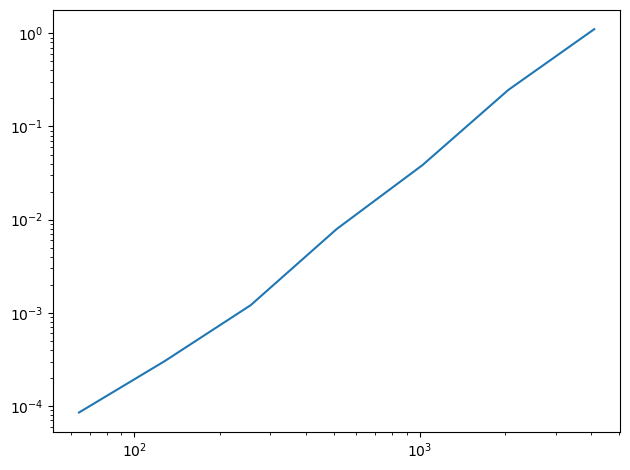

In [8]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

По результатам analyze1 видно, что у
Угол наклона близок к 2, а не к 3, как ожидалось. Одна из причин - это производительность np.linalg.solve почти квадратичная в этом диапазоне размеров массива.

Перейдём к analyze2:

In [9]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
49.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
219 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
731 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
4.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
19.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
82.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
296 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1237772627138343

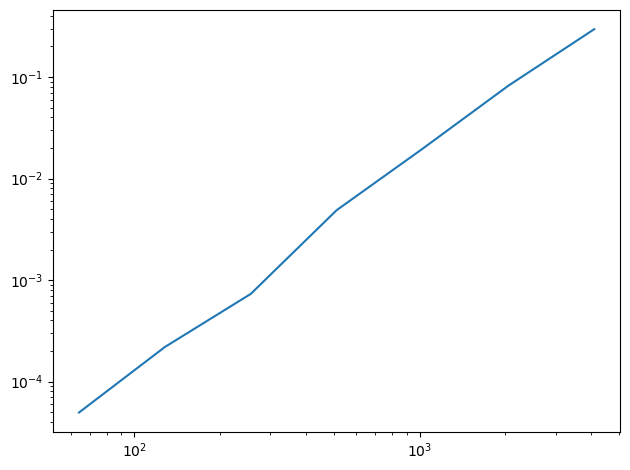

In [10]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

У analyze2 угол наклона близок к 2, как и ожидалось.

Переуём к dct_iv и scipy.fftpack.dt:

In [12]:
def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
8.17 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
7.69 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
8.12 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
9.31 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
12 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
2048
18.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
4096
32.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


0.3251209234748151

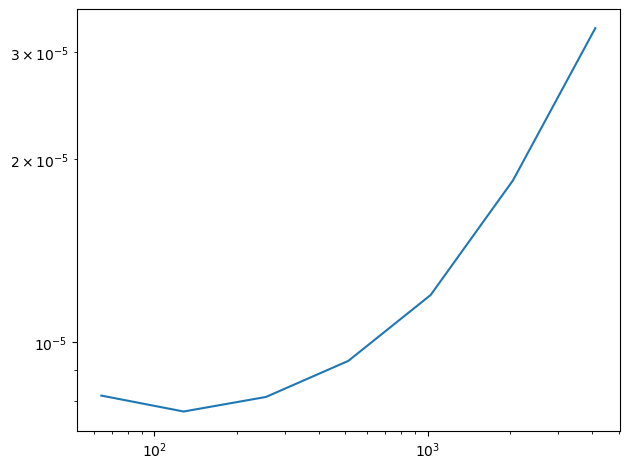

In [13]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Угол наклона у dct нелинейный, значит что до асимптотического поведения она еще не дошла или это поведение не экспонента от n.

### Упражнение 6.2
Одно из основных применений ДКП - это сжатие звука и изображений. В простейшей форме ДКП при сжатии работает следующим образом:

Разбивает длинный сигнал на сегменты.
Вычисляет ДКП каждого сегмента.
Определяет частотные компоненты с амплитудой, что их не слышно, и удаляет их, сохраняя только оставшиеся частоты и амплитуды.
При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.
Реализуйте версию алгоритма и примените его для записи музыки или речи. Сколько компонент можно удалить до того, как разница станет заметной?

### Решение

Воспользуюсь уже имеющимся звуком саксофона

In [15]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/Yuichir0/Telecom/100475__iluppai__saxophone-weep.wav
wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Возьму небольшой сегмент

In [17]:
segment = wave.segment(start=4, duration=0.5)
segment.normalize()
segment.make_audio()

Построю ДКП этого сегмента

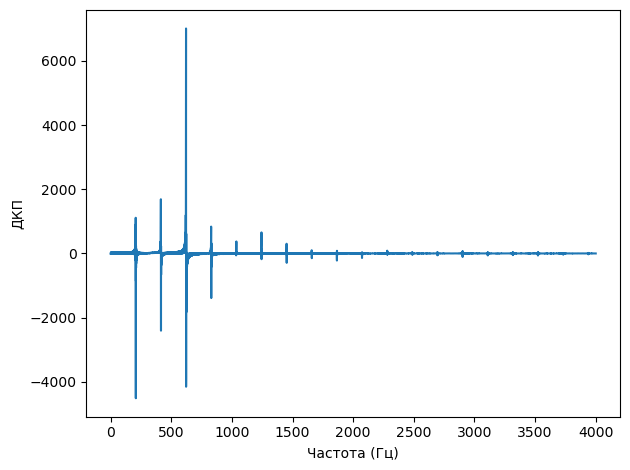

In [19]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Частота (Гц)', ylabel='ДКП')

Можно увидеть несколько гармоник.
Сократим звуки, тише определенного порога

20523	22050	93.07482993197279


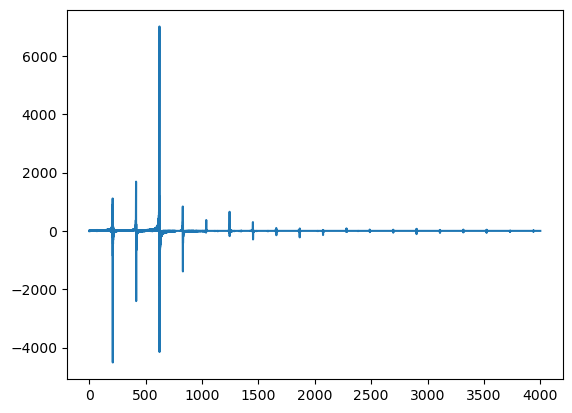

In [21]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

Послушаем результат

In [22]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Если прислушаться, то можно заметить, что обработанный звук менее насыщенный, но разница едва различима (или мне просто послышалось)

Сделаю ДКП спектрограмму и применю сжатие к каждому сегменту

In [28]:
def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.1)

1005	1024	98.14453125
1004	1024	98.046875
996	1024	97.265625
1010	1024	98.6328125
1011	1024	98.73046875
1005	1024	98.14453125
1001	1024	97.75390625
1006	1024	98.2421875
1006	1024	98.2421875
997	1024	97.36328125
1000	1024	97.65625
1006	1024	98.2421875
1006	1024	98.2421875
1003	1024	97.94921875
1005	1024	98.14453125
1004	1024	98.046875
1000	1024	97.65625
1007	1024	98.33984375
1000	1024	97.65625
1005	1024	98.14453125
1001	1024	97.75390625
1009	1024	98.53515625
1007	1024	98.33984375
1008	1024	98.4375
947	1024	92.48046875
675	1024	65.91796875
673	1024	65.72265625
874	1024	85.3515625
933	1024	91.11328125
926	1024	90.4296875
905	1024	88.37890625
851	1024	83.10546875
709	1024	69.23828125
744	1024	72.65625
763	1024	74.51171875
792	1024	77.34375
808	1024	78.90625
807	1024	78.80859375
819	1024	79.98046875
839	1024	81.93359375
845	1024	82.51953125
825	1024	80.56640625
819	1024	79.98046875
843	1024	82.32421875
840	1024	82.03125
840	1024	82.03125
847	1024	82.71484375
825	1024	80.56640625
853	1024	83

Послушаем, что получилось

In [29]:
wave2 = spectro.make_wave()
wave2.make_audio()

Оригинал для сравнения

In [27]:
wave.make_audio()

На сжатом аудио слышны помехи, за их исключением аудио похоже на оригинал

### Упражнение 6.3
В репозитории этой книги есть блокнот Jupyter под названием phase.ipynb в котором исследуется влияние фазы на восприятие звука. Прочтите этот блокнот и "погоняйте" примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

### Решение

Воспользуюсь уже загруженным аудио

In [40]:
wave = read_wave('100475__iluppai__saxophone-weep.wav')
segment = wave.segment(start=1.5, duration=1)
segment.make_audio()

In [46]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Частота (Гц)', 
             ylabel='Фаза (радиан)')
     

def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

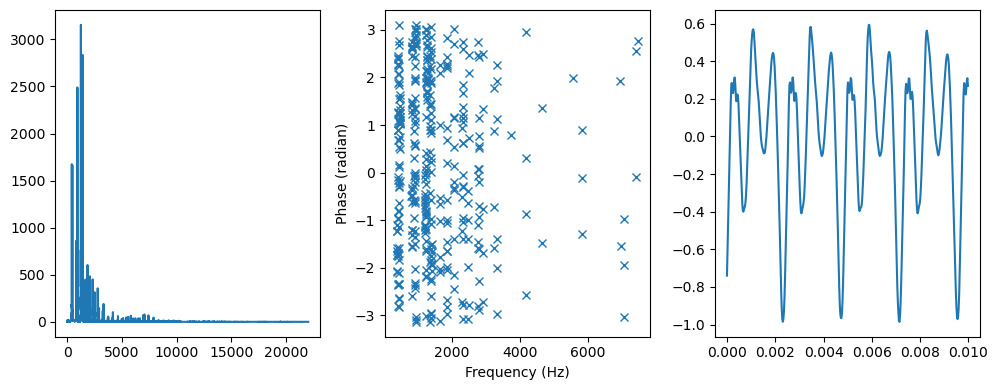

In [42]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Попробую установить нулевые углы

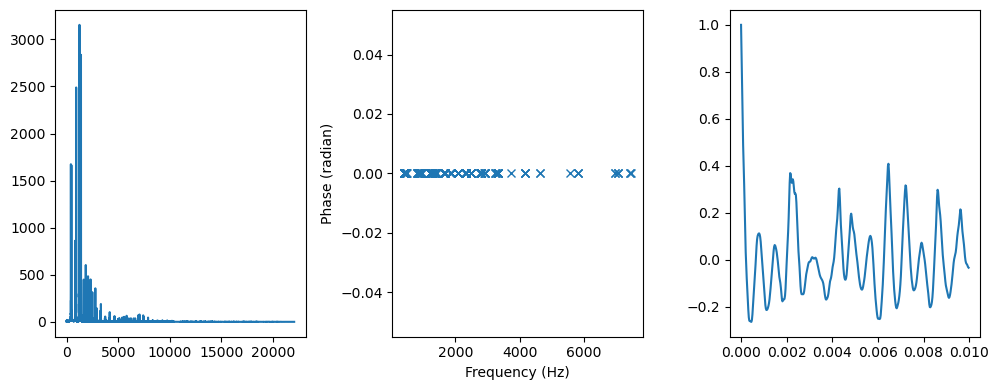

In [43]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res
     
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Теперь углы в 1 градус

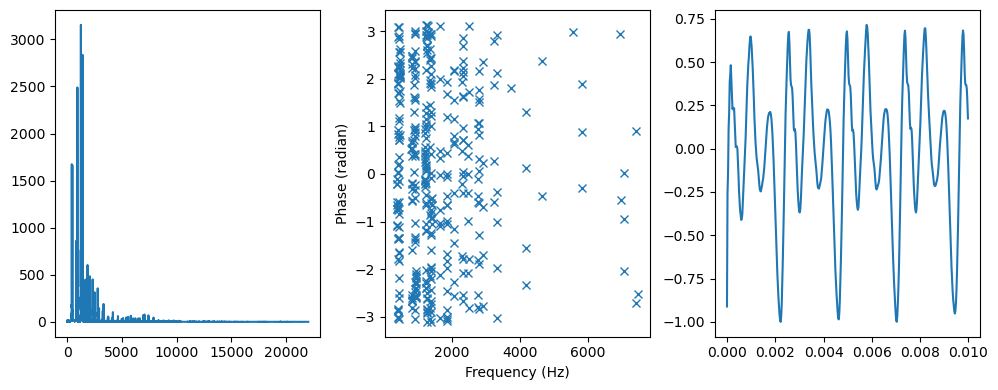

In [44]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res
     
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Также поставлю случайные углы

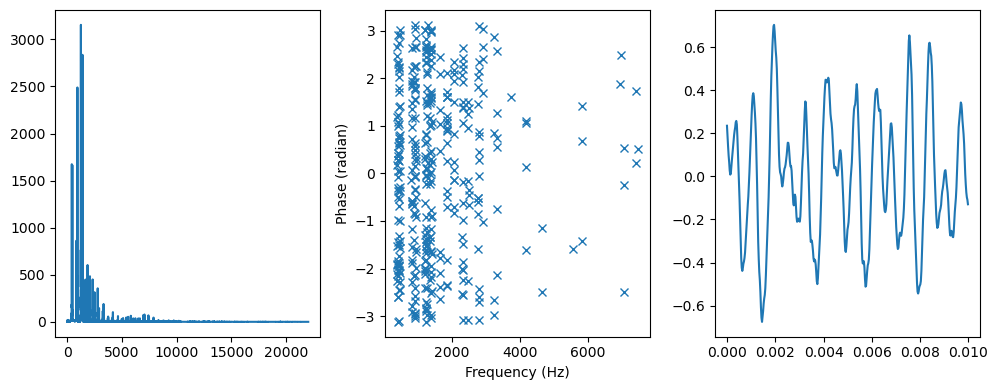

In [45]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, np.pi*2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res
     
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Выбранный звук явно чувствителен к изменению фазовой структуры